## Preparation

In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import torch
from torch.utils.data import DataLoader
from torch.nn import functional as F

import cloud_utils
from UNet import UNet_no_physical

In [2]:
# Magic command to reload packages whenever we run any later cells.
%load_ext autoreload
%autoreload 2

In [3]:
# Set PATH variables
trainset_path = Path('../../data/38-cloud/38-Cloud_training')
testset_path  = Path('../../data/38-cloud/38-Cloud_test')

In [4]:
device = 'cuda:6' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda:6


## Data preprocessing

In [5]:
# Some hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 20 # 50
TRAIN_PERCENT = 0.8 # 80% of the data is used for training, 20% for validation
model_name = '38-cloud-unet-nophy-ep20-lr0p005.pth'

In [6]:
all_train_set = cloud_utils.CloudDataset(
    trainset_path/'train_red',
    trainset_path/'train_green',
    trainset_path/'train_blue',
    trainset_path/'train_nir',
    trainset_path/'train_gt'
)

In [7]:
# Create a list to store the indices of non-empty images
try:
	non_empty_train_indices = []
	with open('./extra_data/non_empty_train_indices.txt','r') as f:
		for line in f:
			non_empty_train_indices.append(int(line.strip()))
except:
	non_empty_train_indices = [i for i, record in enumerate(all_train_set)
						 if record[0].max() != 0]
	with open('./extra_data/non_empty_train_indices.txt', 'w') as f:
		for i in non_empty_train_indices:
			f.write(str(i) +'\n')

print(f'{len(non_empty_train_indices)} out of {len(all_train_set)} are valid masks in trainset.')

5587 out of 8400 are valid masks in trainset.


In [8]:
# use the valid indices to filter the trainset
filtered_trainset = torch.utils.data.Subset(all_train_set, non_empty_train_indices)
# use 80% of the data for training and 20% for validation
train_size = int(TRAIN_PERCENT * len(filtered_trainset))
valid_size = len(filtered_trainset) - train_size
train_set, valid_set = torch.utils.data.random_split(filtered_trainset,
                                                     [train_size, valid_size])
train_dl = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True)
print(f'train_set size: {len(train_set)} \t valid_set size: {len(valid_set)}')
print(f'train_dl size: {len(train_dl)} \t valid_dl size: {len(valid_dl)}')

train_set size: 4469 	 valid_set size: 1118
train_dl size: 140 	 valid_dl size: 35


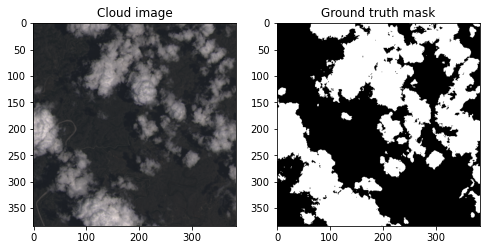

In [9]:
example_id = 3
example_image_no_nir = torch.tensor(all_train_set.open_as_array(example_id))
example_image = all_train_set.open_as_array(example_id, include_nir=True)
example_image = torch.tensor(example_image).unsqueeze(0).permute(0, 3, 1, 2)
exmample_gt_mask = torch.tensor(all_train_set.open_mask(example_id))
cloud_utils.show_one_image_and_mask_info(example_image_no_nir, exmample_gt_mask)

## Model training pipeline

In [10]:
model = UNet_no_physical(in_channels=4, out_channels=2).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
epoch_train_loss_list, epoch_train_iou_list = [], []
epoch_val_loss_list, epoch_val_iou_list = [], []

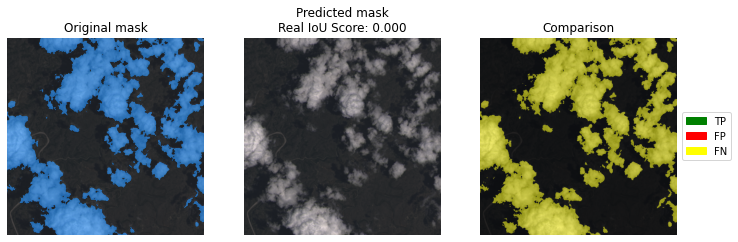

In [11]:
model.eval()
with torch.no_grad():
	exmaple_output = model(example_image.to(device, dtype=torch.float32)).cpu()
	exmaple_pred_mask = F.softmax(exmaple_output[0], 0).argmax(0)
	cloud_utils.show_prediction_results(exmaple_pred_mask, exmample_gt_mask, example_image_no_nir)

Epoch 1/20


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Validating: 100%|██████████| 35/35 [01:19<00:00,  2.28s/it]


Train loss: 0.47, Train IoU: 0.57	Val loss: 0.77, Val IoU: 0.22	Memory used: 0.15GB


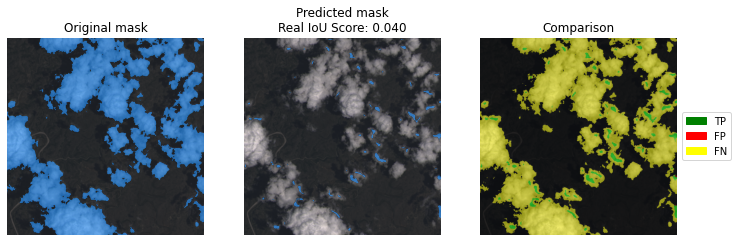

Epoch 2/20


Validating: 100%|██████████| 35/35 [01:20<00:00,  2.29s/it]


Train loss: 0.41, Train IoU: 0.63	Val loss: 0.61, Val IoU: 0.59	Memory used: 0.15GB


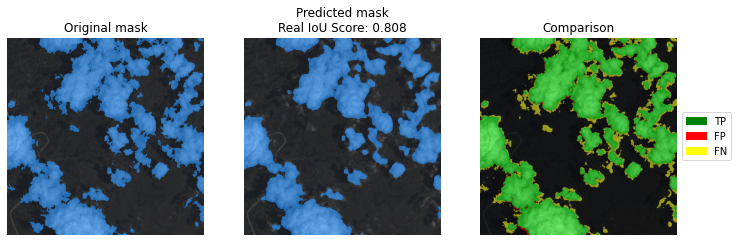

Epoch 3/20


Validating: 100%|██████████| 35/35 [01:16<00:00,  2.18s/it]


Train loss: 0.35, Train IoU: 0.67	Val loss: 0.34, Val IoU: 0.72	Memory used: 0.15GB


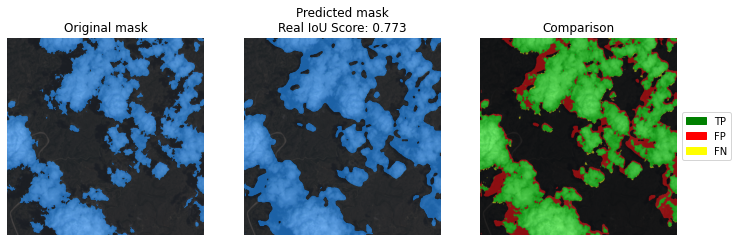

Epoch 4/20


Validating: 100%|██████████| 35/35 [01:18<00:00,  2.26s/it]


Train loss: 0.32, Train IoU: 0.69	Val loss: 0.41, Val IoU: 0.60	Memory used: 0.15GB


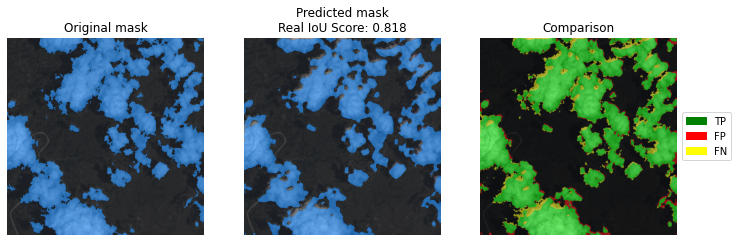

Epoch 5/20


Validating: 100%|██████████| 35/35 [01:17<00:00,  2.23s/it]


Train loss: 0.28, Train IoU: 0.70	Val loss: 0.38, Val IoU: 0.62	Memory used: 0.15GB


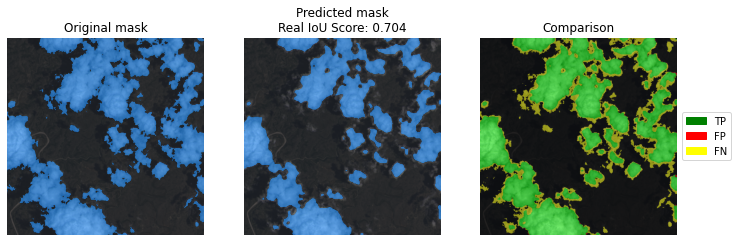

Epoch 6/20


Validating: 100%|██████████| 35/35 [01:17<00:00,  2.22s/it]


Train loss: 0.26, Train IoU: 0.72	Val loss: 0.29, Val IoU: 0.75	Memory used: 0.15GB
Epoch 7/20


Validating: 100%|██████████| 35/35 [01:16<00:00,  2.19s/it]


Train loss: 0.25, Train IoU: 0.72	Val loss: 0.59, Val IoU: 0.50	Memory used: 0.15GB
Epoch 8/20


Validating: 100%|██████████| 35/35 [01:19<00:00,  2.26s/it]


Train loss: 0.24, Train IoU: 0.73	Val loss: 0.36, Val IoU: 0.74	Memory used: 0.15GB
Epoch 9/20


Validating: 100%|██████████| 35/35 [01:16<00:00,  2.20s/it]


Train loss: 0.23, Train IoU: 0.73	Val loss: 0.25, Val IoU: 0.71	Memory used: 0.15GB
Epoch 10/20


Validating: 100%|██████████| 35/35 [01:17<00:00,  2.21s/it]


Train loss: 0.22, Train IoU: 0.74	Val loss: 0.21, Val IoU: 0.76	Memory used: 0.15GB


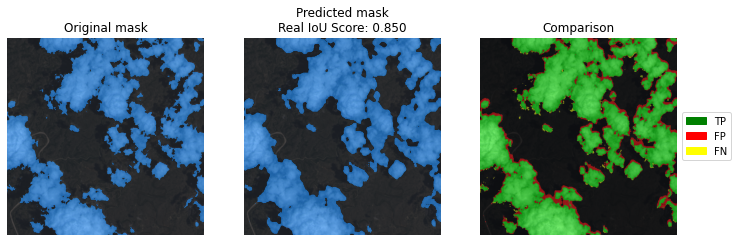

Epoch 11/20


Validating: 100%|██████████| 35/35 [01:17<00:00,  2.22s/it]


Train loss: 0.21, Train IoU: 0.75	Val loss: 0.21, Val IoU: 0.78	Memory used: 0.15GB
Epoch 12/20


Validating: 100%|██████████| 35/35 [01:18<00:00,  2.23s/it]


Train loss: 0.20, Train IoU: 0.75	Val loss: 0.31, Val IoU: 0.75	Memory used: 0.15GB
Epoch 13/20


Validating: 100%|██████████| 35/35 [01:17<00:00,  2.21s/it]


Train loss: 0.20, Train IoU: 0.76	Val loss: 0.22, Val IoU: 0.77	Memory used: 0.15GB
Epoch 14/20


Validating: 100%|██████████| 35/35 [01:16<00:00,  2.19s/it]


Train loss: 0.19, Train IoU: 0.76	Val loss: 0.23, Val IoU: 0.72	Memory used: 0.15GB
Epoch 15/20


Validating: 100%|██████████| 35/35 [01:16<00:00,  2.18s/it]


Train loss: 0.19, Train IoU: 0.76	Val loss: 0.29, Val IoU: 0.69	Memory used: 0.15GB


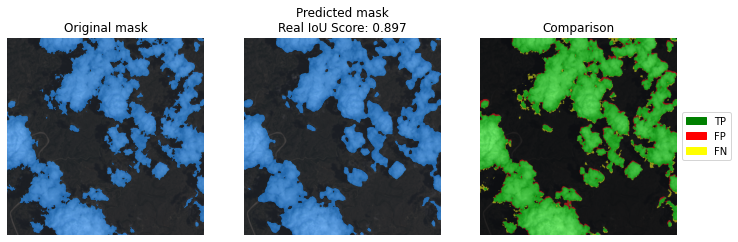

Epoch 16/20


Validating: 100%|██████████| 35/35 [01:18<00:00,  2.25s/it]


Train loss: 0.19, Train IoU: 0.76	Val loss: 0.21, Val IoU: 0.76	Memory used: 0.15GB
Epoch 17/20


Validating: 100%|██████████| 35/35 [01:16<00:00,  2.19s/it]


Train loss: 0.19, Train IoU: 0.76	Val loss: 0.15, Val IoU: 0.79	Memory used: 0.15GB
Epoch 18/20


Validating: 100%|██████████| 35/35 [01:17<00:00,  2.21s/it]


Train loss: 0.19, Train IoU: 0.76	Val loss: 0.22, Val IoU: 0.72	Memory used: 0.15GB
Epoch 19/20


Validating: 100%|██████████| 35/35 [01:15<00:00,  2.15s/it]


Train loss: 0.18, Train IoU: 0.77	Val loss: 0.38, Val IoU: 0.63	Memory used: 0.15GB
Epoch 20/20


Validating: 100%|██████████| 35/35 [01:17<00:00,  2.23s/it]


Train loss: 0.18, Train IoU: 0.77	Val loss: 0.24, Val IoU: 0.69	Memory used: 0.15GB


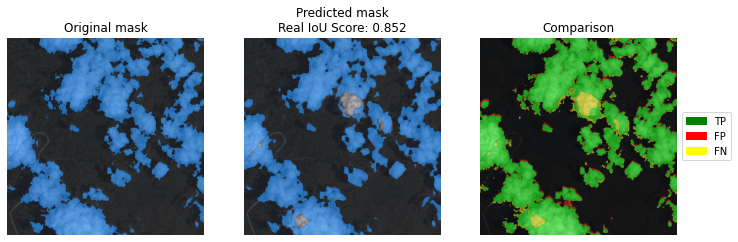

In [12]:
best_iou = 0.5
for epoch in range(NUM_EPOCHS):
	print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
	model.train()
	epoch_train_loss, epoch_train_iou_score = 0.0, 0.0
	for batch in tqdm(train_dl, desc='Training'):
		images_batch, masks_batch = batch
		images_batch = images_batch.to(device=device, dtype=torch.float32)
		masks_batch = masks_batch.to(device=device)
		optimizer.zero_grad()
		outputs = model(images_batch)
		loss = loss_fn(outputs, masks_batch.long())
		loss.backward()
		optimizer.step()
		epoch_train_loss += loss.item()
		iou_score = cloud_utils.compute_IoU(outputs, masks_batch)
		epoch_train_iou_score += iou_score.item()

	epoch_train_loss /= len(train_dl)
	epoch_train_loss_list.append(epoch_train_loss)
	epoch_train_iou_score /= len(train_dl)
	epoch_train_iou_list.append(epoch_train_iou_score)

	model.eval()
	epoch_val_loss, epoch_val_iou_score = 0.0, 0.0
	with torch.no_grad():
		for batch in tqdm(valid_dl, desc='Validating'):
			images_batch, masks_batch = batch
			images_batch = images_batch.to(device=device, dtype=torch.float32)
			masks_batch = masks_batch.to(device=device, dtype=torch.float32)
			outputs = model(images_batch)
			loss = loss_fn(outputs, masks_batch.long())
			epoch_val_loss += loss.item()
			iou_score = cloud_utils.compute_IoU(outputs, masks_batch)
			epoch_val_iou_score += iou_score.item()
		epoch_val_loss /= len(valid_dl)
		epoch_val_iou_score /= len(valid_dl)
		epoch_val_loss_list.append(epoch_val_loss)
		epoch_val_iou_list.append(epoch_val_iou_score)

		print(f'Train loss: {epoch_train_loss_list[-1]:.2f}, ' +
				f'Train IoU: {epoch_train_iou_list[-1]:.2f}\t' +
				f'Val loss: {epoch_val_loss_list[-1]:.2f}, ' +
				f'Val IoU: {epoch_val_iou_list[-1]:.2f}\t' +
				f'Memory used: {torch.cuda.memory_allocated(device)/1e9:.2f}GB')

		if (epoch < 5) or (epoch+1) % 5 == 0:
			exmaple_output = model(example_image.to(device, dtype=torch.float32)).cpu()
			exmaple_pred_mask = F.softmax(exmaple_output[0], 0).argmax(0)
			cloud_utils.show_prediction_results(exmaple_pred_mask, exmample_gt_mask,
									example_image_no_nir)

		if epoch_val_iou_score > best_iou:
			best_iou = epoch_val_iou_score
			torch.save(model.state_dict(), './model/'+model_name)

In [13]:
# exmaple_output = model(example_image.to(device, dtype=torch.float32)).cpu()
# exmaple_pred_mask = F.softmax(exmaple_output[0], 0).argmax(0)
# cloud_utils.show_prediction_results(exmaple_pred_mask, exmample_gt_mask, example_image_no_nir)

In [14]:
print('Training loss per epoch:')
print(epoch_train_loss_list)
print('Validation loss per epoch:')
print(epoch_val_loss_list)
print('Training IoU per epoch:')
print(epoch_train_iou_list)
print('Validation IoU per epoch:')
print(epoch_val_iou_list)

Training loss per epoch:
[0.4678172298840114, 0.4113745934196881, 0.34691143823521475, 0.31557147268738067, 0.28417437470385004, 0.257051481200116, 0.25169324278831484, 0.23798866995743342, 0.22796630268650395, 0.22246384870793137, 0.20702568462916782, 0.20149857758411338, 0.1969411516296012, 0.19371973861541067, 0.19023815712758474, 0.19389171020260879, 0.1924799525312015, 0.19079674381230557, 0.1821938054902213, 0.1764323978019612]
Validation loss per epoch:
[0.770363609279905, 0.6135189763137272, 0.33517400196620395, 0.4094953221934182, 0.3771083001579557, 0.2945004309926714, 0.5948400625160762, 0.363357846226011, 0.25173541818346296, 0.21167878955602645, 0.21000184757368906, 0.3063112722975867, 0.21553524221692766, 0.22636663828577314, 0.2900368315832956, 0.20530184762818474, 0.1506991141608783, 0.22390662623303279, 0.3771289063351495, 0.24446597950799123]
Training IoU per epoch:
[0.572115252486297, 0.6256194306271416, 0.6736944079399109, 0.6892307830708367, 0.702035888178008, 0.72

Text(0.5, 1.0, 'Training and Validation Loss')

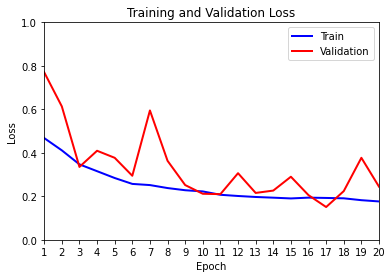

In [19]:
# plot training loss and validation loss in the same figure
plt.figure()
plt.plot(epoch_train_loss_list, label='Train', c='b', lw=2)
plt.plot(epoch_val_loss_list, label='Validation', c='r', lw=2)
plt.legend()
plt.xlabel('Epoch')
plt.xlim(0, NUM_EPOCHS-1)
plt.xticks(ticks=range(NUM_EPOCHS), labels=[str(i+1) for i in range(NUM_EPOCHS)])
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.title('Training and Validation Loss')

Text(0.5, 1.0, 'Training and Validation IoU score')

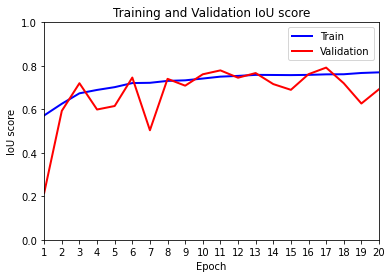

In [16]:
# plot training loss and validation loss in the same figure
plt.figure()
plt.plot(epoch_train_iou_list, label='Train', c='b', lw=2)
plt.plot(epoch_val_iou_list, label='Validation', c='r', lw=2)
plt.legend()
plt.xlabel('Epoch')
plt.xlim(0, NUM_EPOCHS-1)
plt.xticks(ticks=range(NUM_EPOCHS), labels=[str(i+1) for i in range(NUM_EPOCHS)])
plt.ylabel('IoU score')
plt.ylim(0, 1)
plt.title('Training and Validation IoU score')

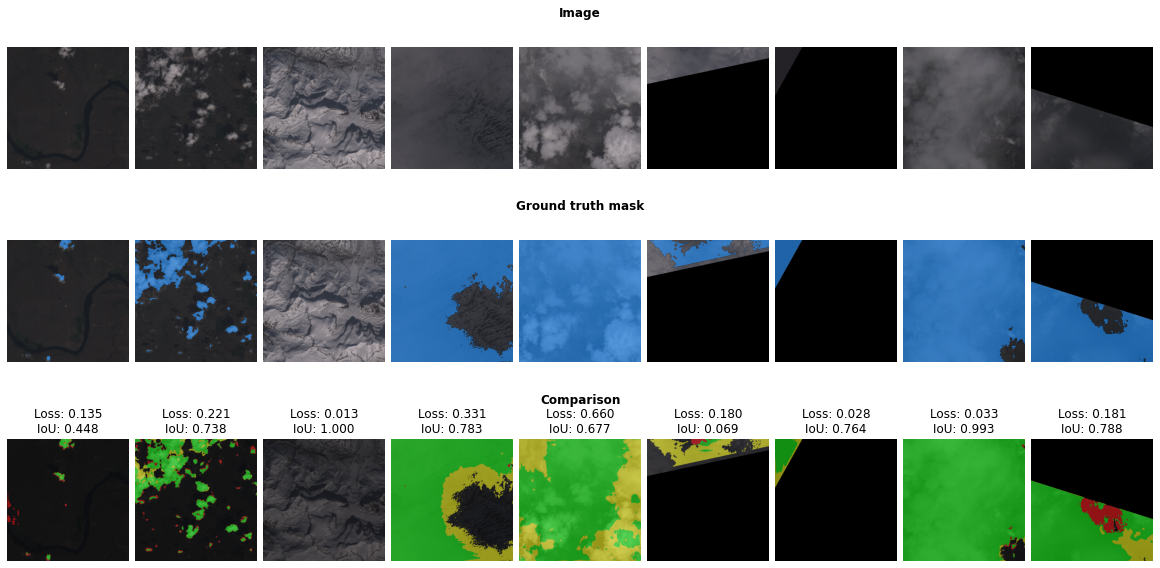

In [17]:
fig = plt.figure(figsize=(16, 8), constrained_layout=True)
subfigs = fig.subfigures(nrows=3, ncols=1)
subfigs[0].suptitle('Image', fontweight='bold')
subfigs[1].suptitle('Ground truth mask', fontweight='bold')
subfigs[2].suptitle('Comparison', fontweight='bold')
ax0 = subfigs[0].subplots(nrows=1, ncols=9)
ax1 = subfigs[1].subplots(nrows=1, ncols=9)
ax2 = subfigs[2].subplots(nrows=1, ncols=9)
for i in range(9):
	image, true_mask = filtered_trainset[i+9]
	image_no_nir = image[:3,:,:]
	image_no_nir = image_no_nir.permute(1, 2, 0)
	ax0[i].imshow(image_no_nir)
	ax0[i].axis('off')
	ax1[i].imshow(image_no_nir)
	cloud_utils.show_mask(true_mask, ax1[i])
	ax1[i].axis('off')
	model.eval()
	with torch.no_grad():
		pred_output = model(image.unsqueeze(0).to(device, dtype=torch.float32)).cpu()
		pred_mask = F.softmax(pred_output[0], 0).argmax(0)
		iou = cloud_utils.compute_IoU_per_image(pred_mask, true_mask)
		loss = loss_fn(pred_output, true_mask.unsqueeze(0).long())
		ax2[i].set_title(f"Loss: {loss:.3f}\nIoU: {iou:.3f}")
		cloud_utils.plot_mask_comparison(pred_mask, true_mask, image_no_nir,
								   		 ax2[i], has_legend=False)
		ax2[i].axis('off')

## Verification